In [267]:
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
from skimage.transform import rescale, resize, downscale_local_mean
from operator import itemgetter
from PIL import Image, ImageDraw
# from mpl_toolkits.basemap import Basemap
# Make Matplotlib plots appear inline
%matplotlib inline

In [5]:
ais_data = pd.read_csv('~/Desktop/challenge_ais.csv')
ais_data.columns
        

Index(['﻿FID', 'mmsi', 'imo', 'vessel_name', 'callsign', 'vessel_type',
       'vessel_type_code', 'vessel_type_cargo', 'vessel_class', 'length',
       'width', 'flag_country', 'flag_code', 'eta', 'draught', 'segment',
       'from_longitude', 'from_latitude', 'longitude', 'latitude', 'sog',
       'cog', 'rot', 'heading', 'nav_status', 'nav_status_code', 'source',
       'ts_pos_utc', 'ts_static_utc', 'dt_pos_utc', 'dt_static_utc',
       'vessel_type_main', 'vessel_type_sub'],
      dtype='object')

In [36]:
long = ais_data['longitude'].as_matrix()
lat = ais_data['latitude'].as_matrix()
time = pd.to_datetime(ais_data['dt_pos_utc']).as_matrix()
time = (time - time[0]) / 1000000000
print(time)
last_pt = [lat[-1], long[-1]]
print(last_pt)

[    0  3960  7440 21840 24840 29220 32760 35340 39900]
[34.380099999999999, 125.13630000000001]


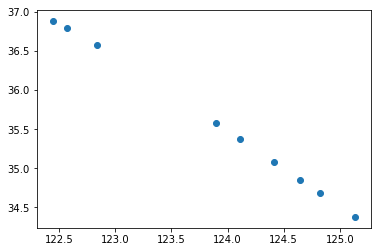

In [98]:
plt.scatter(long, lat)

In [177]:
lat_long = np.vstack((lat, long)).T
dist_traveled = []
vel_at_points = []
for i in range(1, len(lat_long)):
    dist = np.sqrt(np.sum(np.square(lat_long[i] - lat_long[i-1])))
    dist_traveled.append(dist)
    orientation = (lat_long[i] - lat_long[i-1]) / dist
    vel_at_points.append(np.append(orientation, 3600 * dist / (float(time[i] - time[i-1]))))
    
dist_traveled = np.asarray(dist_traveled)
vel_at_points = np.asarray(vel_at_points)
avg_vel = np.average(vel_at_points[:,2])
print(avg_vel)
print(vel_at_points)

0.322319970426
[[-0.54019214  0.84154171  0.13816633]
 [-0.63155059  0.77533467  0.3575764 ]
 [-0.68878922  0.72496166  0.36353647]
 [-0.67744167  0.7355765   0.35090844]
 [-0.69729556  0.71678372  0.34583711]
 [-0.69866101  0.71545286  0.33914753]
 [-0.70090263  0.71325697  0.33883219]
 [-0.69334221  0.72060848  0.3445553 ]]


In [91]:
def get_boundaries(center, width, height):
    left = center[0] - width / 2
    right = center[0] + width / 2
    top = center[1] - height / 2
    bottom = center[1] + height / 2
    return([(left, top), (right, bottom)])

def get_square(delt):
    min_lat = last_pt[0] - avg_vel * delt
    max_lat = last_pt[0] + avg_vel * delt
    min_long = last_pt[1] - avg_vel * delt
    max_long = last_pt[1] + avg_vel * delt
    
    return((min_lat, min_long), (max_lat, max_long))

def get_circle(start_pt, delt, gran, num_top):
    min_lat = start_pt[0] - 2 * avg_vel * delt
    max_lat = start_pt[0] + 2 * avg_vel * delt
    min_long = start_pt[1] - 2 * avg_vel * delt
    max_long = start_pt[1] + 2 * avg_vel * delt
    
    print(min_lat, max_lat)
    print(min_long, max_long)
    
    im = np.zeros(shape=gran)
    
    lats = np.zeros(gran[0])
    longs = np.zeros(gran[1])
    
    cell_width = (max_lat - min_lat) / gran[0]
    cell_height = (max_long - min_long) / gran[1]
    
    for i in range(len(lats)):
        lats[i] = min_lat + (max_lat - min_lat) * (2*i + 1) / (2*len(lats))
    for i in range(len(longs)):
        longs[i] = min_long + (max_long - min_long) * (2*i + 1) / (2*len(longs))
    
    print(lats, longs)
    
    top_regions = []
    
    for i in range(len(lats)):
        for j in range(len(longs)):
            pt_dist = np.sqrt(np.sum(np.square([lats[i] - start_pt[0], longs[j] - start_pt[1]])))
            heat = -np.absolute(pt_dist - avg_vel * delt) / avg_vel
            im[i][j] = heat
            top_regions.append([heat, get_boundaries([lats[i], longs[j]], cell_width, cell_height)])
    
    top_regions = sorted(top_regions, key=itemgetter(0))
    top_regions = top_regions[::-1]
    aoi = [v[1] for v in top_regions[:num_top]]
    print(aoi)
    
    return im, top_regions[:num_top]
    

In [92]:
get_square(10)

((31.156900295737941, 121.91310029573795),
 (37.603299704262056, 128.35949970426205))

In [99]:
im, top = get_circle(last_pt, 10, (10, 10), 10)

27.9337005915 40.8264994085
118.689900591 131.582699409
[ 28.57834053  29.86762041  31.1569003   32.44618018  33.73546006
  35.02473994  36.31401982  37.6032997   38.89257959  40.18185947] [ 119.33454053  120.62382041  121.9131003   123.20238018  124.49166006
  125.78093994  127.07021982  128.3594997   129.64877959  130.93805947]
[[(30.512260354885534, 125.13630000000001), (31.801540236590355, 126.42557988170483)], [(30.512260354885534, 123.84702011829518), (31.801540236590355, 125.13630000000001)], [(33.090820118295177, 121.26846035488553), (34.380100000000006, 122.55774023659036)], [(36.958659763409642, 125.13630000000001), (38.247939645114471, 126.42557988170483)], [(36.958659763409642, 123.84702011829518), (38.247939645114471, 125.13630000000001)], [(34.380099999999999, 121.26846035488553), (35.669379881704828, 122.55774023659036)], [(33.090820118295177, 127.71485976340966), (34.380100000000006, 129.00413964511449)], [(34.380099999999999, 127.71485976340966), (35.669379881704828, 1

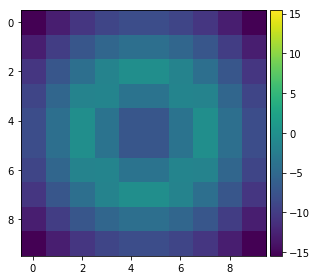

In [100]:
skimage.io.imshow(im, cmap=plt.cm.viridis)
plt.show()

In [250]:
CLIP_LOW = -20.0
CLIP_HIGH = 20.0

def get_heat_trajectory(start_pt, ranges, vel, traj, delt, gran, num_top):
#     min_lat = start_pt[0] - 2 * vel * delt
#     max_lat = start_pt[0] + 2 * vel * delt
#     min_long = start_pt[1] - 2 * vel * delt
#     max_long = start_pt[1] + 2 * vel * delt
    
    min_lat = ranges[0]
    max_lat = ranges[1]
    min_long = ranges[2]
    max_long = ranges[3]
    
    best_pt = vel * delt * traj + start_pt
    
    print(best_pt)
    
    im = np.zeros(shape=gran)
    
    lats = np.zeros(gran[0])
    longs = np.zeros(gran[1])
    
    cell_width = (max_lat - min_lat) / gran[0]
    cell_height = (max_long - min_long) / gran[1]
    
    for i in range(len(lats)):
        lats[i] = min_lat + (max_lat - min_lat) * (2*i + 1) / (2*len(lats))
    for i in range(len(longs)):
        longs[i] = min_long + (max_long - min_long) * (2*i + 1) / (2*len(longs))
    
#     print(lats, longs)
    
    top_regions = []
    
    for i in range(len(lats)):
        for j in range(len(longs)):
            if is_land(lats[i], longs[j]):
                im[i][j] = CLIP_HIGH
            else:
                pt_dist = np.sqrt(np.sum(np.square([lats[i] - start_pt[0], longs[j] - start_pt[1]])))
                heat = -np.absolute(pt_dist - vel * delt) / vel
                bestpt_dist = np.sqrt(np.sum(np.square([lats[i] - best_pt[0], longs[j] - best_pt[1]])))
                heat = heat - 2* bestpt_dist / vel
                if heat < CLIP_LOW:
                    heat = CLIP_LOW
                im[i][j] = heat
                top_regions.append([heat, get_boundaries([lats[i], longs[j]], cell_width, cell_height)])
    
    top_regions = sorted(top_regions, key=itemgetter(0))
    top_regions = top_regions[::-1]
    aoi = [v[1] for v in top_regions[:num_top]]
    print(aoi)
    
    return im, top_regions[:num_top]
    

In [282]:
min_lat = last_pt[0] - 5
max_lat = last_pt[0] + 5
min_long = last_pt[1] - 5
max_long = last_pt[1] + 5
ranges = [min_lat, max_lat, min_long, max_long]

im, top = get_heat_trajectory(last_pt, ranges, avg_vel, vel_at_points[-1][:2], 2.5, (50, 50), 10)
rotated = im[::-1]

[  33.8214049   125.71696626]
[[(33.780099999999997, 125.53630000000001), (33.9801, 125.7363)], [(33.780099999999997, 125.73630000000001), (33.9801, 125.9363)], [(33.580099999999995, 125.53630000000001), (33.780099999999997, 125.7363)], [(33.580099999999995, 125.73630000000001), (33.780099999999997, 125.9363)], [(33.9801, 125.73630000000001), (34.180100000000003, 125.9363)], [(33.580099999999995, 125.33630000000001), (33.780099999999997, 125.5363)], [(33.9801, 125.53630000000001), (34.180100000000003, 125.7363)], [(33.780099999999997, 125.33630000000001), (33.9801, 125.5363)], [(33.780099999999997, 125.93630000000002), (33.9801, 126.13630000000001)], [(33.380099999999999, 125.53630000000001), (33.580100000000002, 125.7363)]]


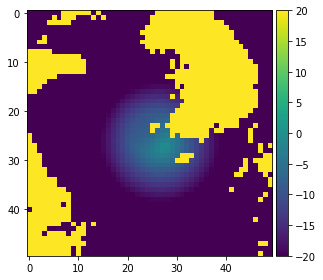

In [283]:
skimage.io.imshow(rotated, cmap=plt.cm.viridis)
image_resized = resize(rotated, (800, 400))
plt.show()

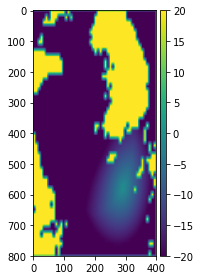

In [269]:
skimage.io.imshow(image_resized, cmap=plt.cm.viridis)
plt.show()

In [ ]:
def wrapper_get_boxes(last_pt, vel, traj, delt, num_boxes):
    

In [223]:
img = Image.open('/Users/anshulramachandran/Desktop/worldmask.png')
worldmask = np.asarray(list(img.getdata())).reshape((5400, 10800))

In [224]:
def is_land(lat, long):
    pixel_long = int((long + 180.0) * 10800.0 / 360.0)
    pixel_lat = int((90.0 - lat) * 5400.0 / 180.0)
#     worldmask2 = worldmask
#     worldmask2[pixel_lat-500:pixel_lat+500, pixel_long-500:pixel_long+500] = 0
#     img = Image.fromarray(np.uint8(worldmask2))
#     img.show()
    if worldmask[pixel_lat][pixel_long] == 0:
        return False
    else:
        return True

In [226]:
is_land(35.4, 127)

True